In [1]:
from operator import itemgetter

In [44]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.base import clone, BaseEstimator, TransformerMixin
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from basedir import SAMPLE
from info import id_cols
from utils import to_feather, from_feather, starts, dropcols, float64

In [4]:
seed = 1
np.random.seed(seed)

In [5]:
rcParams['figure.figsize'] = 10, 8

In [6]:
x_trn, y_trn, x_tst = from_feather('x_trn', 'y_trn', 'x_tst')

In [7]:
ids = x_trn.series_id.unique()

In [8]:
sample = np.random.choice(ids, 3)

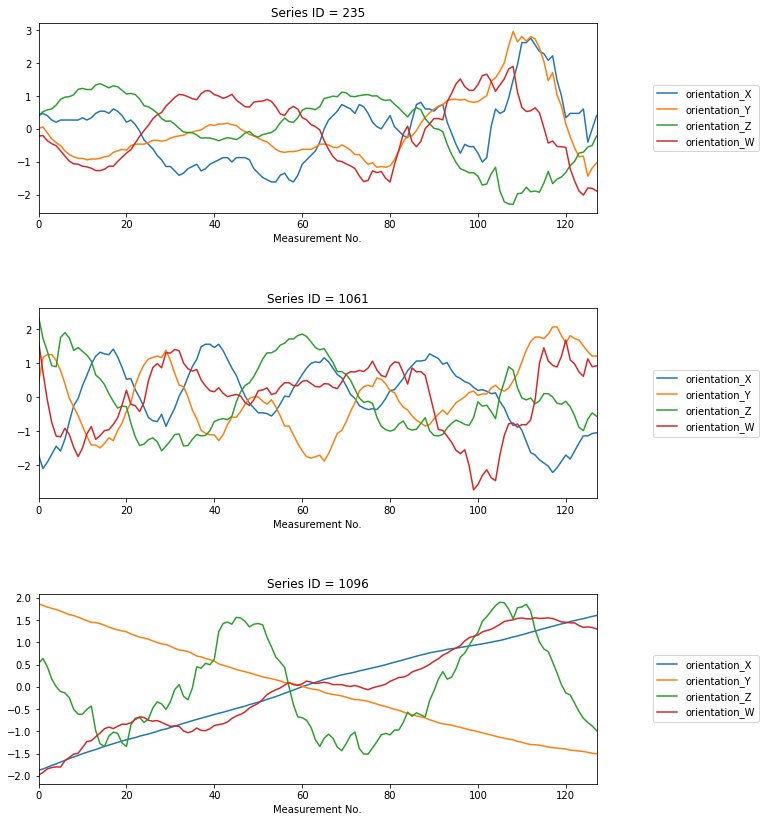

In [9]:
groups = x_trn[x_trn.series_id.isin(sample)].groupby('series_id')
f, axes = plt.subplots(len(sample), 1, figsize=(10, 14))
f.subplots_adjust(hspace=0.5)
for ax, (series_id, group) in zip(axes.flat, groups):
    group = group.copy()
    x = group.measurement_number.values
    group = group[starts(group, 'orient')]
    scaled = StandardScaler().fit_transform(float64(group))
    scaled = pd.DataFrame(scaled, columns=group.columns)
    scaled['x'] = x
    scaled.plot(x='x', ax=ax)
    ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
    ax.set_title(f'Series ID = {series_id}')
    ax.set_xlabel('Measurement No.')

In [10]:
trn_ids, val_ids = train_test_split(ids, stratify=y_trn.surface, test_size=0.2, random_state=seed)

In [11]:
trn_df = x_trn[x_trn.series_id.isin(trn_ids)]
val_df = x_trn[x_trn.series_id.isin(val_ids)]

In [12]:
feat_cols = [col for col in trn_df.columns if col not in id_cols]

In [13]:
trn_vec = np.row_stack([
    group[feat_cols].T.values.flatten() 
    for _, group in trn_df.groupby('series_id')])

trn_target = y_trn.surface[y_trn.series_id.isin(trn_ids)]

val_vec = np.row_stack([
    group[feat_cols].T.values.flatten()
    for _, group in val_df.groupby('series_id')])

val_target = y_trn.surface[y_trn.series_id.isin(val_ids)]

In [45]:
model = lgb.LGBMClassifier(n_estimators=1000, 
                           learning_rate=0.1,
                           objective='multiclass',
                           num_class=9)

In [42]:
def accuracy(y_true, y_pred):
    breakpoint()
    y_hat = y_pred.reshape(9).argmax(axis=1)
    value = (y_true == y_hat).mean()
    return 'accuracy', value, True

In [46]:
model.fit(trn_vec, trn_target,
          eval_set=[(val_vec, val_target)],
          verbose=10, early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's multi_logloss: 1.27761
[20]	valid_0's multi_logloss: 0.992293
[30]	valid_0's multi_logloss: 0.863
[40]	valid_0's multi_logloss: 0.794323
[50]	valid_0's multi_logloss: 0.747519
[60]	valid_0's multi_logloss: 0.725738
[70]	valid_0's multi_logloss: 0.720771
[80]	valid_0's multi_logloss: 0.716958
[90]	valid_0's multi_logloss: 0.72222
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.716062


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_class=9, num_leaves=31,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [51]:
preds = model.predict(val_vec)

In [52]:
cm = confusion_matrix(val_target, preds)

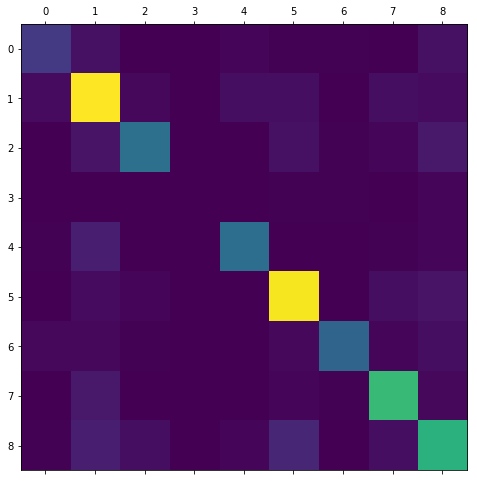

In [55]:
plt.matshow(cm)

In [38]:
tst_vec = np.row_stack([
    group[feat_cols].T.values.flatten() 
    for _, group in x_tst.groupby('series_id')])

In [39]:
preds = model.predict(tst_vec)

In [40]:
submit = pd.read_csv(SAMPLE)
submit['surface'] = preds
submit.to_csv('submit.csv', index=None)

In [41]:
!kaggle c submit career-con-2019 -f 'submit.csv' -m "Naive LightGBM with multi_logloss"

100%|██████████████████████████████████████| 52.4k/52.4k [00:00<00:00, 69.5kB/s]
Successfully submitted to CareerCon 2019 - Help Navigate Robots 